## Assignment - 1: Data Curation
#### Vishnu Nandakumar

This notebook provides a detailed overview of the steps involved in fetching and processing the Wikipedia page views data from January 1st, 2008 till September 30, 2018.

The process can be broadly divided into three parts:
 - Data acquisition : Acquiring the data through Wikipedia API and save them.
 - Data processing : Processing the saved data to prepare them for analysis. 
 - Analysis : Visualizing the dataset created in previous step as a time series graph. 


First lets import the required packages.

In [1]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

#### Common variables

In [2]:
# Defining request headers and map for various website types. 
HEADERS={'User-Agent' : 'https://github.com/vivanvish', 'From' : 'vishnn@uw.edu'}
FILE_NAME_FORMAT = '{apiname}_{accesstype}_{start}-{end}.json'
LEGACY_API_NAME = 'pagecounts'
PAGEVIEW_API_NAME = 'pageviews'

### Function to hit the provided API and retrieve data.

In [3]:
def get_data(api_endpoint, site_type, params):
    """
        Function to retrieve the data from the provided API.
        Args:
            api_endpoint(str): Endpoint of the api.
            site_type(str): Desktop or mobile or app.
            params(dict): Dictionary of Request parameters.
            
        Returns:
            response(json): Returns pagecount data in json format.
    """
    # populating access point.
    params['access'] = site_type
    # Filling in the request body and generating get request. 
    call = requests.get(api_endpoint.format(**params), headers=HEADERS)
    # Getting data in json format.
    response = call.json()
    return response

## Part 1: Data Acquisition

#### There are two data sources here: The pagecounts API and pageviews API. Pagecounts API is the older of the two and has info on mobile and desktop web traffic data. The pageviews API is the newer one. It can provide desktop and mobile web traffic, as well as, mobile app traffic data.  

### Legacy API 

###### This step involves hitting the Wikipedia Legacy Pagecounts API to fetch the monthly pageview counts data for both mobile and desktop traffic from from January 1, 2008 till July 31, 2016. The data are stored as json files.

In [4]:
# Legacy API endpoint
legacy_endpoint = (
    'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/'
    '{project}/{access}/{granularity}/{start}/{end}'
)

# Defining common request parameters. 
# This specifies to retrieve monthly aggregated data, from user level traffic
# between 2008/01 till 2016/08. 
legacy_request_params = {
    'project' : 'en.wikipedia.org',
    'granularity' : 'monthly',
    'agent':'user',
    'start' : '2008010100',
    'end' : '2016080100'
}

legacy_supported_sites = ('desktop-site', 'mobile-site')

# Getting data for each site type and write to disk
for site_type in legacy_supported_sites:
    data = get_data(legacy_endpoint, site_type, legacy_request_params)
    
    #File name will be of format "apiname_accesstype_firstmonth-lastmonth.json"
    filename = FILE_NAME_FORMAT.format(
        apiname=LEGACY_API_NAME,
        accesstype=site_type,
        start=legacy_request_params['start'][:-4],
        end="201607"
    )
    
    with open('data/{}'.format(filename), 'w') as outfile:
        json.dump(data, outfile) 

### Pageview API

#### Here I am using the latest wikipedia api: Pageview API, for retrieving the pagecount data from July 2015 through September 2018. The Pageview api can also provide data from the wikipedia mobile app. The data are stored as json files.

In [5]:
pageview_endpoint = (
    'https://wikimedia.org/api/rest_v1/metrics/'
    'pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
)

# The dates are July, 2015 - Sept 31, 2018 
pageview_request_params = {
    'project' : 'en.wikipedia.org',
    'granularity' : 'monthly',
    'agent':'user',
    'start' : '2015070100',
    'end' : '2018100100'
}

#Pageview supports mobileapp, desktop and mobile web traffic
pageview_supported_sites = ('desktop', 'mobile-web', 'mobile-app')

# Getting data for each site type and write to disk
for site_type in pageview_supported_sites:
    data = get_data(pageview_endpoint, site_type, pageview_request_params)
    
    #File name will be of format "apiname_accesstype_firstmonth-lastmonth.json"
    filename = FILE_NAME_FORMAT.format(
        apiname=PAGEVIEW_API_NAME,
        accesstype=site_type,
        start=pageview_request_params['start'][:-4],
        end="201809"
    )
    
    with open('data/{}'.format(filename), 'w') as outfile:
        json.dump(data, outfile) 

## Part 2 : Data processing
The json files are opened and processed to obtain the final analytical dataset.
There are three steps involved in this stage:
- Monthly data from mobile web and app retrieved using the pageviews API will be combined to form the total mobile traffic data from pageviews.
- The date will be split into years(YYYY) and month (MM) and the rest (day and hour) are discared. 
- If data is not present for a given month then it will be filled with 0.
- The final processed data will be a dataframe with the following structure:

<img src="dataframe.png" alt="Drawing" style="width: 200px;"/>



Function to get list of data files retrieved using the given API. 
Filters the filenames based on wherther their name contains the API name passed as arguement.

In [6]:
def get_api_specific_files(api_name):
    files = [file for file in os.listdir('data/') if api_name in file]
    return files

Function to convert a json file to dataframe format. The json data is in the form of list of records under the key 'items'. Hence in order to create a pandas dataframe I extracted the value of key 'items' from the json data.  

In [7]:
def convert_json_to_dataframe(json_file):
    with open('data/' + file) as data_file:    
        data = json.load(data_file)
        df = pd.DataFrame(data['items'])
        return df

#### Processing Pageview API data.
- Reading pageview json files and converting to dataframes.
- Pageview dataframe contains the following columns: `access` , `agent`, `granularity`, `project`,`timestamp` and `views`
- Concatenating all dataframes, retaining necessary columns like `access`, `timestamp` and `views`, where `access` is the site type (desktop, mobile, etc) and `views` is the pageview count.
- Pivoting to get the dataframe in a proper format.
- Filling any NaNs with zeroes.
- Renaming `desktop` to `pageview_desktop_views`.
- Adding `mobile-app` and `mobile-web` counts to get get `pageview_mobile_views`.
- Adding `pageview_desktop_views` and `pageview_mobile_views` to get `pageview_all_views`
- Dropping now unwanted columns like `access`, `mobile-app` and `mobile-web`.


In [10]:
dataframes = []
pageview_files = get_api_specific_files(PAGEVIEW_API_NAME)
for file in pageview_files:
    df = convert_json_to_dataframe(file)
    dataframes.append(df)
pageview_df = pd.concat(dataframes)
#Keeping only necessary columns.
pageview_df = pageview_df[["access","timestamp","views"]]
pageview_df = pageview_df.pivot(index="timestamp",columns="access",values="views").reset_index()
pageview_df = pageview_df.fillna(0)
pageview_df = pageview_df.rename(columns={'desktop':'pageview_desktop_views'})
pageview_df['pageview_mobile_views'] = pageview_df['mobile-app']+pageview_df['mobile-web']
pageview_df['pageview_all_views'] = pageview_df['pageview_desktop_views']+pageview_df['pageview_mobile_views']
pageview_df = pageview_df.drop(['mobile-app' ,'mobile-web'],axis=1)
#Cleaning unwanted index names that crops up during pivotting.
pageview_df = pageview_df.rename_axis(None, axis=1).reset_index(drop=True) 

#### The pageview dataframe sample after processing.

In [11]:
pageview_df.head()

,timestamp,pageview_desktop_views,pageview_mobile_views,pageview_all_views
0,2015070100,4376666686,3288755294,7665421980
1,2015080100,4332482183,3302333038,7634815221
2,2015090100,4485491704,3170203333,7655695037
3,2015100100,4477532755,3268499132,7746031887
4,2015110100,4287720220,3236601070,7524321290


#### Repeating the same procedure above for pagecount  data.
- Pagecount dataframe contains the following columns: `access-site` ,  `granularity`, `project`,`timestamp` and `count`
- Concatenating all dataframes, retaining necessary columns like `access-site`, `timestamp` and `count`, where `access-site` is the site type (desktop, mobile, etc) and `count` is the traffic count.
- Pivoting to get the dataframe in a proper format.
- Renaming columns `desktop-site` to `pagecount_desktop_views`and `mobile-site` to `pagecount_mobile_views`.
- Filling any NaNs with zeroes.
- Adding `pagecount_desktop_views` and `pagecount_mobile_views` to get `pagecount_all_views`
- Dropping now unwanted columns like `access-site`


In [12]:
dataframes = []
pagecount_files = get_api_specific_files(LEGACY_API_NAME)
for file in pagecount_files:
    df = convert_json_to_dataframe(file)
    dataframes.append(df)
#Concatenating     
pagecount_df = pd.concat(dataframes)
#Keeping only necessary columns.
pagecount_df = pagecount_df[["access-site","timestamp","count"]]
pagecount_df = pagecount_df.pivot(index="timestamp",columns="access-site",values="count").reset_index()
pagecount_df = pagecount_df.rename(columns={
    'desktop-site':'pagecount_desktop_views',
    'mobile-site':'pagecount_mobile_views'
})
pagecount_df = pagecount_df.fillna(0)
pagecount_df['pagecount_all_views'] = pagecount_df['pagecount_desktop_views']+pagecount_df['pagecount_mobile_views']
#Cleaning unwanted index names that crops up during pivotting.
pagecount_df = pagecount_df.rename_axis(None, axis=1).reset_index(drop=True) 

In [13]:
pagecount_df.head()

,timestamp,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views
0,2008010100,4.930903e+09,0.0,4.930903e+09
1,2008020100,4.818394e+09,0.0,4.818394e+09
2,2008030100,4.955406e+09,0.0,4.955406e+09
3,2008040100,5.159162e+09,0.0,5.159162e+09
4,2008050100,5.584691e+09,0.0,5.584691e+09


### Merging both dataframes to get the final analytical dataset.
Here we need to use `outer` join and fill all NaNs with 0s.

In [14]:
final_df = pd.merge(pagecount_df,pageview_df,on='timestamp',how='outer')
final_df = final_df.fillna(0)

### Before saving the file, we need to split  `timestamp` into `month` and `year` and then drop the `timestamp` column.

In [15]:
#The year is the first four characters in timestamp and the month follows after it.
final_df['year'] = final_df['timestamp'].str[0:4]
final_df['month'] = final_df['timestamp'].str[4:6]
final_df.drop('timestamp',axis=1, inplace=True)
final_df = final_df[["year","month","pagecount_all_views","pagecount_desktop_views","pagecount_mobile_views","pageview_all_views","pageview_desktop_views","pageview_mobile_views"]]

In [16]:
final_df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
1,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
2,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
3,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0
4,2008,05,5.584691e+09,5.584691e+09,0.0,0.0,0.0,0.0


#### Saving the data.

In [17]:
final_df.to_csv('data/en-wikipedia_traffic_200712-201809.csv',index=False)

### Part 3: Analysis

This part basically covers visualizing the data as time-series sequences. We can see how Wikipedia usage has shifted across time.
- For plotting convenience I am concatenating the year and month column to get a time series.

In [18]:
#Reading in the analytic dataset.
wikidata_df = pd.read_csv('data/en-wikipedia_traffic_200712-201809.csv')
wikidata_df['time'] = pd.to_datetime(wikidata_df[['year', 'month']].assign(Day=1))
wikidata_df.drop(['year','month'],axis=1,inplace=True)
wikidata_df = wikidata_df.set_index('time')
wikidata_df = wikidata_df.divide(1000000,axis=1)
#Replacing 0s with NaNs to hide 0s in the plot.
wikidata_df = wikidata_df.replace(to_replace=0,value=np.nan)

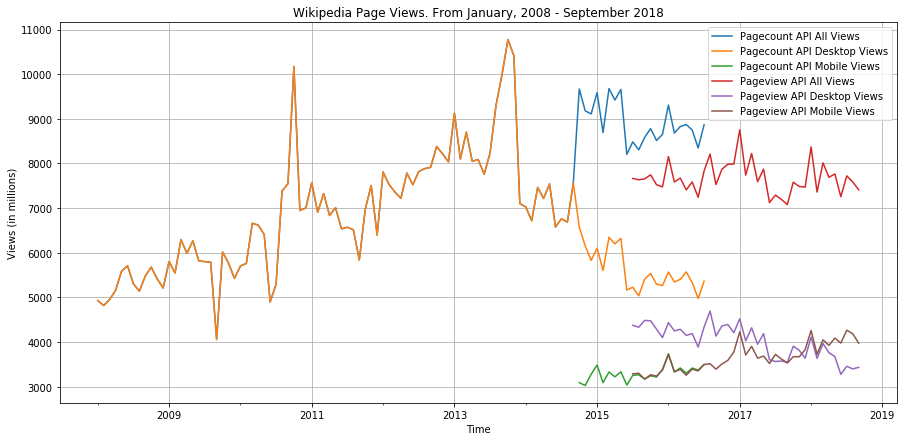

In [19]:
fig = plt.figure(figsize = (15,7))
ax = fig.gca()
wikidata_df.plot(ax=ax)
ax.grid(True)
ax.set_xlabel('Time')
ax.set_ylabel('Views (in millions)')
ax.set_title('Wikipedia Page Views. From January, 2008 - September 2018')
custom_legend_labels = ['Pagecount API All Views','Pagecount API Desktop Views', 'Pagecount API Mobile Views',
                        'Pageview API All Views', 'Pageview API Desktop Views', 'Pageview API Mobile Views']
legend = ax.legend(labels=custom_legend_labels)
#Saving the Figure
fig.savefig('wiki_pageviews_2008_2018.png')